# FOOD VISION 101  🍔 🍉 🥘 🍲 🔭 📷

## INTRODUCTION
Deep learning is a vast field with numerous applications. In this project i'd be building an **ended to ended** multi-class image classification system to classify 101 diffrent classes of food type. I'll be implementing the popular **CNN network** while utilizing the full power of **feature extraction**,**fine tuning** and **transfer learning** to extract features and fine-tune layer.

As an introductory project to myself, I worked out with a pretrained Image Classification Model that comes with **TF HUB** and then retrained it on the famous **Food101 Dataset**.

...more

## AIM
Apart from building an end to end image classification system, the sole aim of the project is to beat the DeepFood Paper's model which is also trained on the same dataset(Food101).

The Accuracy of [**DeepFood**](https://arxiv.org/abs/1606.05675) was **77.4%** and our model's is **82%**. Difference of **8%** ain't much but the interesting thing is, DeepFood's model took 2-3 days to train while our's was around 60min.

> **Dataset :** `Food101`
> **Model :** `EfficientNetB1`

## Setting up the Workspace
* Checking the GPU
* Mounting Google Drive
* Importing Tensorflow & other required Packages\Libraries

### Checking the GPU
For this Project I'd working with **Mixed Precision**. And mixed precision works best with a with a GPU with compatibility capacity **7.0+**.

Colab allocates a random GPU everytime we factory reset runtime. So you can reset the runtime till you get a **Tesla T4 GPU** as T4 GPU has a rating 7.5.

> In case using local hardware, use a GPU with rating 7.0+ for better results.

Run the below cell to see which GPU is allocated to you.

In [1]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f4919341-5484-a913-ad8b-c76fbc0f3612)


### Mounting Google Drive
Refreshing the work enviroment in google colab results in loose of all variable. It's essential you save your variables and files to google drive for persistence incase of any eventuality. 

In [2]:
#...code to mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Importing Tensorflow & other required Packages\Libraries

In [3]:
# Get helper functions file
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
import os

if not os.path.exists("helper_functions.py"):
    print("Downloading helper functions...")
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("Helper functions file already exists, skipping download...")

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, load_and_prep_image

--2022-07-09 11:54:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-09 11:54:43 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# ...imports
import tensorflow as tf
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import accuracy_score

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Check TensorFlow version (should be 2.4.0+)
print(tf.__version__)
# Hide warning logs (see: https://stackoverflow.com/a/38645250/7900723)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2.8.2


## Gathering Data

In [5]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?

True


In [6]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=False, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteD73OFF/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteD73OFF/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Accessing & Visualizing Data

In [7]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
  


In [12]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [13]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

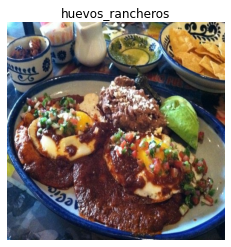

In [14]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Data Preprocessing
Having successfully downloaded the dataset, In other to make the data and the model compatible, some **preprocessing functions** need to be applied so as to transform the data into the required format. This will enable get the best out of the model since deep learning model performs better with good data. 

More specifically, our data is currently:
* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:
* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape)
* Normalized date (values ranging from 0 to 1).

To take care of these, we'll create a `preprocess_img()`

Having successfully transformed the data, the transformed data would be passed through a pipeline for futher processing
- Original dataset(e.g. train_data) ->  processing function  ->  map()  ->  shuffle()  ->  batch()  ->  prefetch()   ->  PrefetchDataset

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816  253.64285  251.      ]
  [222.99998  254.97449  252.19388 ]
  [207.06633  255.       250.36734 ]
  ...
  [140.66287  129.52519  121.22428 ]
  [121.14268  115.265144 116.95397 ]
  [ 83.95363   83.08119   89.63737 ]]

 [[221.47449  254.37755  253.33163 ]
  [214.5102   255.       253.92348 ]
  [198.41327  254.58673  251.96939 ]
  ...
  [208.66318  195.82143  173.40823 ]
  [197.03056  190.1071   174.83162 ]
  [175.54036  171.6169   161.21384 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


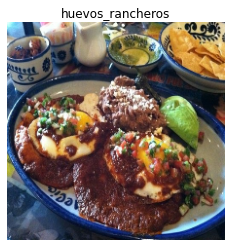

In [17]:
# We can still plot our preprocessed image as long as we 
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32)

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks & Setting mixed precision

- callbacks allows us to make changes to our model while it's training(e.g decrease or increase learning rates)
- Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs

In [20]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved 

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
mixed_precision.global_policy() # should output "mixed_float16"

<Policy "mixed_float16">

## Build feature extraction model
1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3.  Fine-tune if necessary with multiple layers unfrozen


In [ ]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only


x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(.3)(x)


x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                           

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [ ]:
# Fit the model with callbacks
history_feature_extract = model.fit(train_data, 
                                    epochs=5,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", 
                                                                           "efficientnetb0_101_classes_all_data_feature_extract"),
                                               model_checkpoint]
                                   )

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220703-140910
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.2985 - accuracy: 0.6600
Epoch 1: val_loss improved from 1.12321 to 1.10298, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 166s 69ms/step - loss: 1.2985 - accuracy: 0.6600 - val_loss: 1.1030 - val_accuracy: 0.7095
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2597 - accuracy: 0.6671
Epoch 2: val_loss improved from 1.10298 to 1.09141, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 166s 69ms/step - loss: 1.2598 - accuracy: 0.6671 - val_loss: 1.0914 - val_accuracy: 0.7058
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.2390 - accuracy: 0.6697
Epoch 3: val_loss improved from 1.09141 to 1.08806, saving model to model_checkpoints/cp.ckpt
2368/2368 [=============================

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 48s 61ms/step - loss: 1.0730 - accuracy: 0.7094


[1.0730088949203491, 0.7093861103057861]

In [ ]:
# Clone the model we created (this resets all weights)
#cloned_model = tf.keras.models.clone_model(model)
#cloned_model.summary()

In [ ]:
!ls model_checkpoints/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
# ## Saving model to Google Drive (optional)

# # Create save path to drive 
save_dir = "drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
os.makedirs(save_dir) # Make directory if it doesn't exist

# # Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [ ]:
model.save("/content/drive/MyDrive/tensorflow_course/food_vision/ExtractorModel.hdf5")

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 52s 63ms/step - loss: 1.0730 - accuracy: 0.7094


[1.0730093717575073, 0.7093861103057861]

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

## Preparing our model's layers for fine-tuning

Feature-extraction model is showing some great promise after three epochs. But since I got so much data, it's probably worthwhile that we see what results we can get with fine-tuning (fine-tuning usually works best when you've got quite a large amount of data).

Remember our goal of beating the DeepFood paper?

They were able to achieve 77.4% top-1 accuracy on Food101 over 2-3 days of training.

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_saved_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float16 <Policy "float16">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

In [ ]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_fine_tuning = loaded_saved_model.fit(train_data,
                                             epochs=100, # fine-tune for a maximum of 100 epochs
                                             steps_per_epoch=len(train_data),
                                             validation_data=test_data,
                                             validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                             callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                             model_checkpoint, # save only the best model during training
                                             early_stopping, # stop model after X epochs of no improvements
                                             reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220703-143427
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.0432 - accuracy: 0.7195INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 399s 161ms/step - loss: 1.0432 - accuracy: 0.7195 - val_loss: 0.7771 - val_accuracy: 0.7863 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7392 - accuracy: 0.7934INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 390s 164ms/step - loss: 0.7392 - accuracy: 0.7935 - val_loss: 0.7334 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.8480INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 387s 163ms/step - loss: 0.5338 - accuracy: 0.8480 - val_loss: 0.7010 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 333s 140ms/step - loss: 0.3692 - accuracy: 0.8914 - val_loss: 0.7596 - val_accuracy: 0.7979 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.9201
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 333s 140ms/step - loss: 0.2578 - accuracy: 0.9201 - val_loss: 0.7547 - val_accuracy: 0.8075 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - 339s 142ms/step - loss: 0.1017 - accuracy: 0.9714 - val_loss: 0.7446 - val_accuracy: 0.8236 - lr: 2.0000e-05


In [ ]:
# # Save model to Google Drive (optional)
loaded_saved_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


In [ ]:
# Evaluate mixed precision trained loaded model
results_loaded_gs_model_fine_tuned = loaded_saved_model.evaluate(test_data) 
results_loaded_gs_model_fine_tuned

790/790 [==============================] - 51s 65ms/step - loss: 0.7728 - accuracy: 0.8176


[0.7728341817855835, 0.8176237344741821]

In [ ]:
loaded_saved_model.save("/content/drive/MyDrive/tensorflow_course/food_vision/FinalModel.hdf5")

In [22]:
# Load model previously saved above
#model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")
model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow_course/food_vision/EfficientNetB1.hdf5/")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [23]:
# Evaluate mixed precision trained loaded model
results_loaded_model_fine_tuned = model.evaluate(test_data) 
results_loaded_model_fine_tuned

790/790 [==============================] - 64s 64ms/step - loss: 0.6972 - accuracy: 0.8428


[0.697169303894043, 0.8428118824958801]

## Model Evaluation and Visualization

In this section I'd be evaluting the model on diffrent performance metrics(**`accuracy and f1 score`**). I'd also be making a plot to visualize the percision and recall score of the model on different classes of food. 

In [24]:
#perform prediction on the test sets
pred_probs = model.predict(test_data, verbose=1)

len(pred_probs), pred_probs.shape

790/790 [==============================] - 56s 68ms/step


(25250, (25250, 101))

In [25]:
# Retrive the highest prediction probability for each prediction made
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], len(pred_classes), pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), 25250, (25250,))

In [26]:
#test_data.unbatch().take(1)
# Note: This might take a minute or so due to unravelling 790 batches
# Getting true labels for the test_data
y_labels = []

#test_images = []

for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy())
y_labels[:10], len(y_labels)

([29, 81, 91, 53, 97, 97, 10, 31, 3, 100], 25250)

In [36]:
#len(pred_probs[:10][0]), 
#pred_probs[:10].argmax(axis=1)

In [29]:
# Predicted Labels vs. True Labels
pred_classes[200]==y_labels[200]

True

### Sklearn's Accuracy Score

In [30]:
sklearn_acc = accuracy_score(y_labels, pred_classes)
sklearn_acc 

0.8428118811881188

### Confusion Matrix
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known

In [31]:
import seaborn as sn
cm = tf.math.confusion_matrix(y_labels, pred_classes)

plt.figure(figsize = (200, 200));
sn.heatmap(cm, annot=True, 
           fmt='',
           cmap='Blues');

### Model's Class-wise Accuracy Score


In [32]:
from sklearn.metrics import classification_report
report = (classification_report(y_labels, pred_classes, output_dict=True))

In [33]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in report.items():
    if k == "accuracy": # stop once we get to accuracy key
        break
    else:
        # Append class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.5857740585774058,
 'baby_back_ribs': 0.8450704225352113,
 'baklava': 0.8960000000000001,
 'beef_carpaccio': 0.902970297029703,
 'beef_tartare': 0.7891682785299806,
 'beet_salad': 0.7590361445783133,
 'beignets': 0.8611670020120724,
 'bibimbap': 0.9295774647887324,
 'bread_pudding': 0.6469428007889546,
 'breakfast_burrito': 0.7427385892116183,
 'bruschetta': 0.7842323651452283,
 'caesar_salad': 0.8778625954198473,
 'cannoli': 0.9149797570850203,
 'caprese_salad': 0.8715953307392996,
 'carrot_cake': 0.831013916500994,
 'ceviche': 0.7404255319148937,
 'cheese_plate': 0.9028340080971659,
 'cheesecake': 0.7628865979381443,
 'chicken_curry': 0.7773279352226721,
 'chicken_quesadilla': 0.8304093567251462,
 'chicken_wings': 0.888015717092338,
 'chocolate_cake': 0.7290836653386455,
 'chocolate_mousse': 0.6444007858546169,
 'churros': 0.9076305220883534,
 'clam_chowder': 0.9054325955734406,
 'club_sandwich': 0.8779527559055117,
 'crab_cakes': 0.7668593448940271,
 'creme_brulee': 0

In [34]:
report_df = pd.DataFrame(class_f1_scores, index = ['f1-scores']).T

In [35]:
report_df = report_df.sort_values("f1-scores", ascending=True)

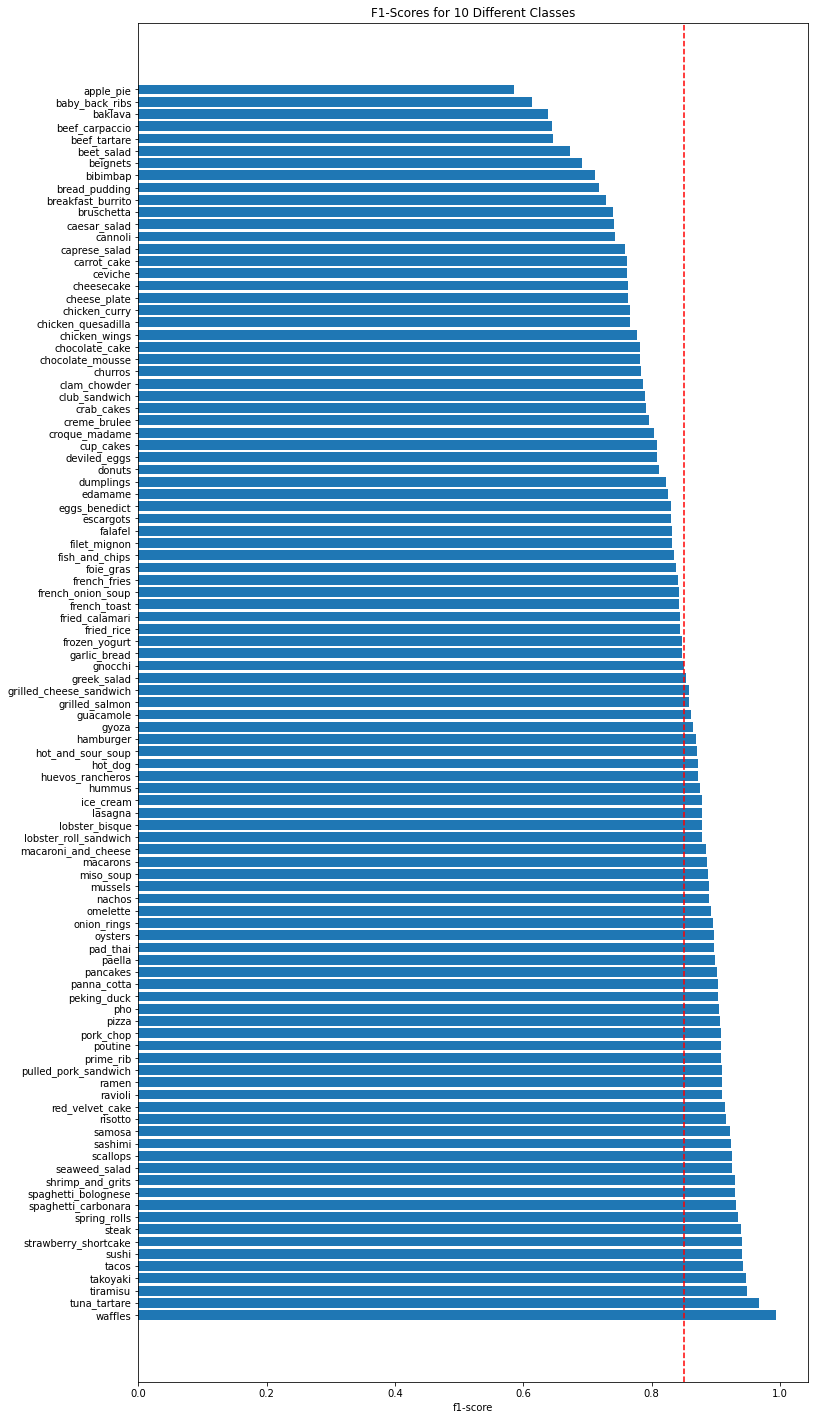

In [36]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(report_df)), report_df["f1-scores"].values)
ax.set_yticks(range(len(report_df)))
plt.axvline(x=0.85, linestyle='--', color='r')
ax.set_yticklabels(class_names)
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

### **Predicting on our own Custom images**

Once we have our model ready, its cruicial to evaluate it on our custom data : the data our model has never seen.

Training and evaluating a model on train and test data is cool, but making predictions on our own realtime images is another level.

In [37]:
# Get custom food images filepaths
import os

custom_food_images = ["/content/drive/MyDrive/FoodVision/images/food_img/" + img_path for img_path in os.listdir("/content/drive/MyDrive/FoodVision/images/food_img")]
custom_food_images

['/content/drive/MyDrive/FoodVision/images/food_img/download (5).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/images (1).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download (4).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/images (4).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download (6).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download (3).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download (1).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download.jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/images (2).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/images.jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download (2).jpeg',
 '/content/drive/MyDrive/FoodVision/images/food_img/download (7).jpeg']

In [42]:
def pred_plot_custom(folder_path):
  import os

  custom_food_images = [folder_path + img_path for img_path in os.listdir(folder_path)]
  i=0
  fig,a =  plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)))

  for img in custom_food_images:
    img = load_and_prep_image(img, scale=False) 
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
    pred_class = class_names[pred_prob.argmax()]
    top_5_i = (pred_prob.argsort())[0][-5:][::-1]
    values = pred_prob[0][top_5_i] 
    labels = []
    for x in range(5):
      labels.append(class_names[top_5_i[x]])

    # Plotting Image
    a[i][0].imshow(img/255.) 
    a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
    a[i][0].axis(False)

    # Plotting Models Top 5 Predictions
    a[i][1].bar(labels, values, color='orange');
    a[i][1].set_title('Top 5 Predictions')
    i=i+1

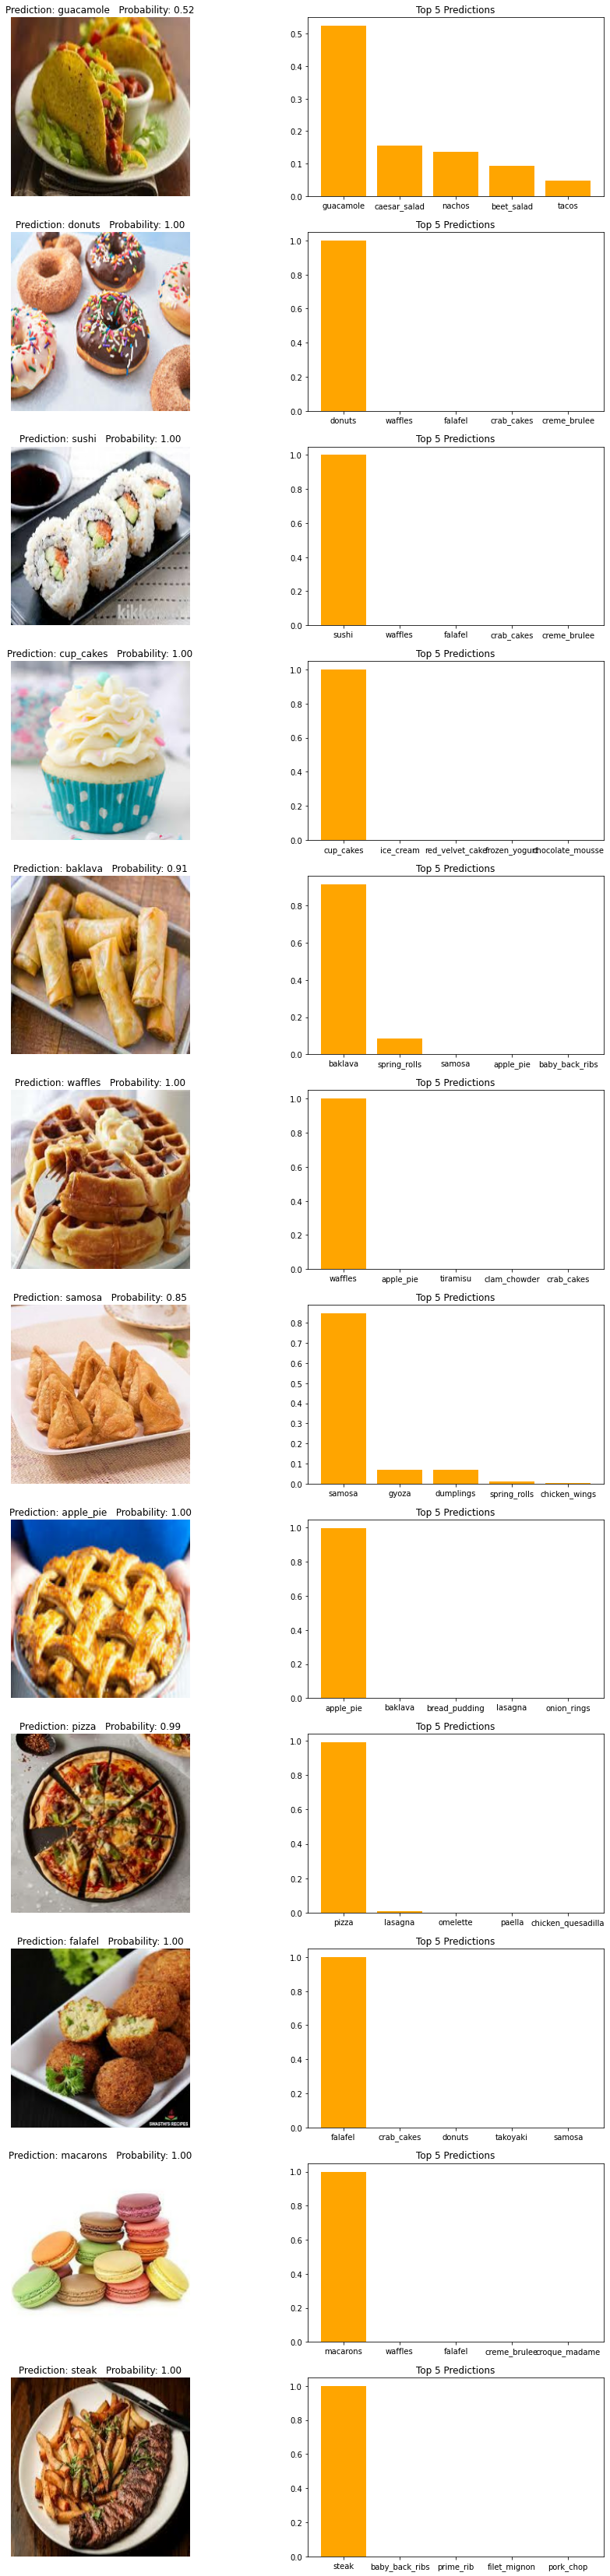

In [43]:
pred_plot_custom("/content/drive/MyDrive/FoodVision/images/food_img/")